In [77]:
import matplotlib.pyplot as plt
import pandas as pd
import re

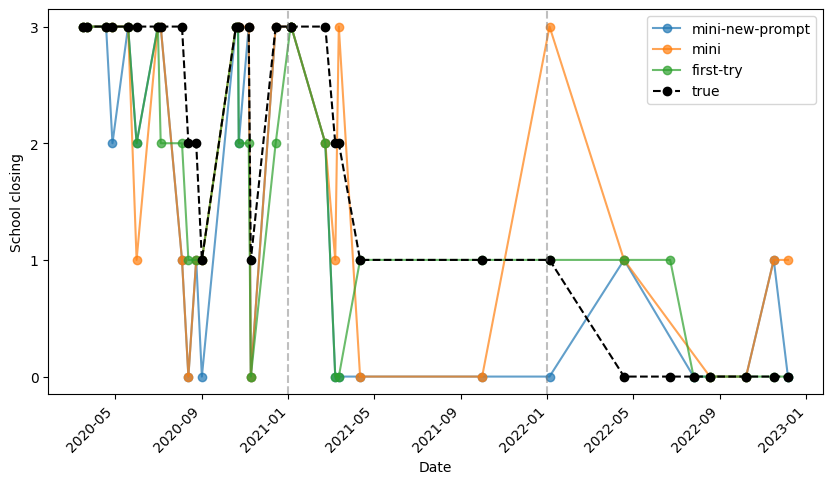

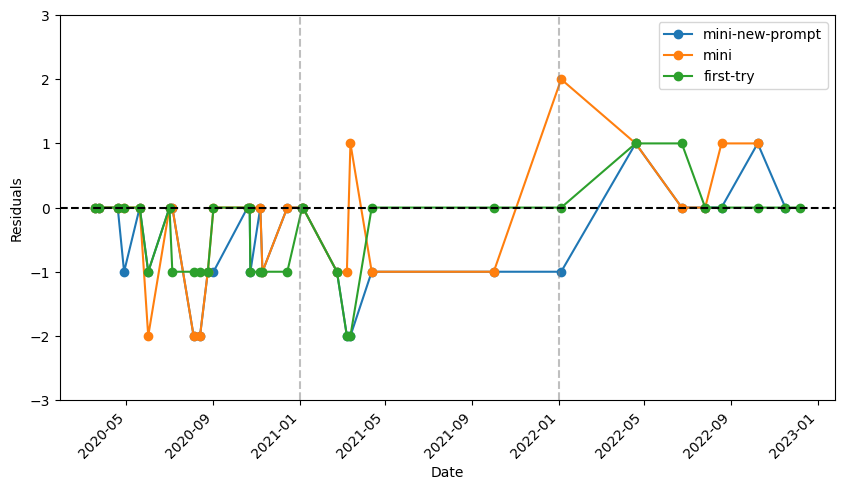

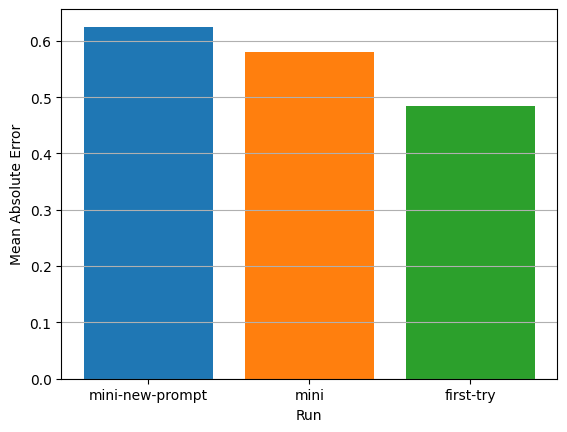

In [79]:
def compare_results(results_dirs: dict[str, str], label_path: str):

    fig, ax = plt.subplots(figsize=(10, 5))

    labels = pd.read_csv(label_path)
    labels["Date"] = pd.to_datetime(labels["Date"])
    labels = labels.sort_values(by="Date")
    labels["Score"] = labels["Score"].astype(int)

    resid_dict = {}

    for label, path in results_dirs.items():
        preds = pd.read_csv(path)
        preds["Date"] = pd.to_datetime(preds["Date"])
        preds = preds.sort_values(by="Date")

        preds["Score"] = preds["Score"].fillna("0")
        preds["Score"] = preds["Score"].astype(str)
        valid_scores = ["0", "1", "2", "3"]
        # any score not in valid scores should be set to 0
        preds["Score"] = preds["Score"].apply(lambda x: x if x in valid_scores else "0")
        preds["Score"] = preds["Score"].astype(int)

        resid_dict[label] = preds["Score"] - labels["Score"]

        ax.plot(preds["Date"], preds["Score"], marker="o", alpha=0.7, label=label)

    ax.plot(labels["Date"], labels["Score"], marker="o", color="black", linestyle="--", label="true")

    ax.axvline(pd.to_datetime("2021-01-01"), color="gray", linestyle="--", alpha=0.5)
    ax.axvline(pd.to_datetime("2022-01-01"), color="gray", linestyle="--", alpha=0.5)

    ax.legend()
    ax.set_xlabel("Date")
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticks([0, 1, 2, 3])
    ax.set_ylabel("School closing")

    plt.show()

    fig, ax = plt.subplots(figsize=(10, 5))
    for label, residuals in resid_dict.items():
        ax.plot(labels["Date"], residuals, marker="o", label=label)

    ax.axvline(pd.to_datetime("2021-01-01"), color="gray", linestyle="--", alpha=0.5)
    ax.axvline(pd.to_datetime("2022-01-01"), color="gray", linestyle="--", alpha=0.5)
    ax.axhline(0, color="black", linestyle="--")

    ax.legend()
    ax.set_xlabel("Date")
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
    ax.set_ylabel("Residuals")

    plt.show()

    mae_dict = dict(resid_dict)
    for label in mae_dict:
        mae_dict[label] = mae_dict[label].abs().mean()
    fig, ax = plt.subplots()
    ax.grid(axis="y")
    ax.bar(mae_dict.keys(), mae_dict.values(), color=[f"C{i}" for i in range(len(mae_dict))])
    ax.set_ylabel("Mean Absolute Error")
    ax.set_xlabel("Run")

    plt.show()


compare_results(
    {"mini-new-prompt": "persistence.csv",
     "mini": "../logs/mini/persistence.csv",
     "first-try": "../logs/uk-first-run/persistence.csv"}
    , "uk.csv")

# compare_results(
#     {
#         "no-history": "persistence.csv"
#     },
#     smaller=True
# )

In [76]:
def get_wrong_with_notes(results_path: str, label_path: str):
    preds = pd.read_csv(results_path)
    labels = pd.read_csv(label_path)

    labels["Date"] = pd.to_datetime(labels["Date"])
    preds["Date"] = pd.to_datetime(preds["Date"])

    labels = labels.merge(preds[["Date", "Score", "Notes"]], on="Date", how="left", suffixes=("", "_Pred"))

    wrong = labels[labels["Score"] != labels["Score_Pred"]]
    for _, row in wrong.iterrows():
        print(row["Date"].date(), row["Score_Pred"], row["Score"])
        print("\t", row["Notes_Pred"])
        print("\t", row["Notes"])

get_wrong_with_notes("persistence.csv", "uk.csv")

2020-06-01 1.0 3.0
	 The article indicates a phased reopening of schools with significant alterations in operations and safety measures, showing a cautious approach rather than a full return to normalcy.
	 From June 1, the government is asking some school levels to open in England. These include nurseries, years 1 and 6 of primary school, and special schools such as hospital schools. The other devolved governments of the UK are not yet asking any school levels to open.     https://web.archive.org/web/20200603201146/https://www.gov.uk/government/publications/closure-of-educational-settings-information-for-parents-and-carers/reopening-schools-and-other-educational-settings-from-1-june
2020-08-04 1.0 3.0
	 The article outlines plans for reopening schools starting August 24, indicating significant alterations rather than complete closure.
	 Schools in Northern Ireland remain closed with a plan to begin to reopen on 24/08.https://web.archive.org/web/20200813090943/https://www.nidirect.gov.u

In [42]:
years = [2020, 2021, 2022]
dfs = []
for year in years:
    dfs.append(pd.read_csv(f"raw/OxCGRT_fullwithnotes_national_{year}_v1.csv"))
df = pd.concat(dfs, ignore_index=True)
df.shape

/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_34806/1818765487.py:4: DtypeWarning: Columns (120,121,129) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(f"raw/OxCGRT_fullwithnotes_national_{year}_v1.csv"))
/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_34806/1818765487.py:4: DtypeWarning: Columns (115) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(f"raw/OxCGRT_fullwithnotes_national_{year}_v1.csv"))


(202760, 147)

In [12]:
for col in df.columns:
    print(col)

CountryName
CountryCode
RegionName
RegionCode
Jurisdiction
Date
C1E_School closing
C1E_Flag
C1NV_School closing
C1NV_Flag
C1V_School closing
C1V_Flag
C1M_School closing
C1M_Flag
C1_Notes
C2E_Workplace closing
C2E_Flag
C2NV_Workplace closing
C2NV_Flag
C2V_Workplace closing
C2V_Flag
C2M_Workplace closing
C2M_Flag
C2_Notes
C3E_Cancel public events
C3E_Flag
C3NV_Cancel public events
C3NV_Flag
C3V_Cancel public events
C3V_Flag
C3M_Cancel public events
C3M_Flag
C3_Notes
C4E_Restrictions on gatherings
C4E_Flag
C4NV_Restrictions on gatherings
C4NV_Flag
C4V_Restrictions on gatherings
C4V_Flag
C4M_Restrictions on gatherings
C4M_Flag
C4_Notes
C5E_Close public transport
C5E_Flag
C5NV_Close public transport
C5NV_Flag
C5V_Close public transport
C5V_Flag
C5M_Close public transport
C5M_Flag
C5_Notes
C6E_Stay at home requirements
C6E_Flag
C6NV_Stay at home requirements
C6NV_Flag
C6V_Stay at home requirements
C6V_Flag
C6M_Stay at home requirements
C6M_Flag
C6_Notes
C7E_Restrictions on internal movement


In [ ]:
c1_cols = ["C1E_School closing", "C1_Notes"]
index_cols = ["CountryName", "CountryCode", "RegionName", "RegionCode", "Jurisdiction", "Date"]
c1 = df[index_cols + c1_cols]
# c1 = c1[c1["RegionName"] == "Texas"]
c1 = c1[c1["CountryName"] == "United Kingdom"]
c1 = c1.dropna(subset=c1_cols)
c1["Date"] = pd.to_datetime(c1["Date"], format="%Y%m%d")
c1 = c1.sort_values(by=["Date"])
c1.head()

34

In [47]:
c1["Jurisdiction"].value_counts()

Jurisdiction
NAT_TOTAL    34
Name: count, dtype: int64

In [15]:
def get_notes_from_date(c1: pd.DataFrame, date: str) -> str:
    date = pd.to_datetime(date, format="%Y-%m-%d")
    subset = c1[c1["Date"] == date]
    notes = subset["C1_Notes"].tolist()[0]
    score = subset["C1E_School closing"].tolist()[0]
    return score, notes

In [16]:
# get_notes_from_date(c1, "2022-01-11")

In [60]:
def extract_urls(text: str) -> list[str]:
    url_pattern = r'https?://[^\s<>"]+|www\.[^\s<>"]+'
    urls = re.findall(url_pattern, text)
    return urls

def create_dataset(c1: pd.DataFrame, smaller: bool = False) -> pd.DataFrame:
    policy = "C1E_School closing"
    data = []
    for i, row in c1.iterrows():
        date = pd.to_datetime(row["Date"], format="%Y%m%d").date()
        score = row[policy]
        country = row["CountryName"]
        urls = extract_urls(row["C1_Notes"])
        if len(urls) > 0:
            url_string = ", ".join(urls)
            to_add = {"Date": date, "Region": country, "Policy": policy, "Score": score, "Source": url_string, "Notes": row["C1_Notes"]}
            data.append(to_add)

    df = pd.DataFrame(data)

    # If smaller is True, keep entries before and after a change in score
    if smaller:
        diff = df["Score"].diff().fillna(0).astype(int)
        change_indices = diff[diff != 0].index.tolist()
        change_indices.extend([i - 1 for i in change_indices if i > 0])
        if len(df) - 1 not in change_indices:
            change_indices.append(len(df) - 1)
        if 0 not in change_indices:
            change_indices.append(0)
        change_indices = sorted(change_indices)
        df = df.iloc[change_indices].copy()
    return df

texas = create_dataset(c1)
texas.head()

,Date,Region,Policy,Score,Source,Notes
0,2020-03-18,United Kingdom,C1E_School closing,3.0,http://web.archive.org/web/20200730045554/http...,"On March 18th, Northern Ireland closed all of ..."
1,2020-03-23,United Kingdom,C1E_School closing,3.0,https://web.archive.org/web/20200320160258/htt...,https://web.archive.org/web/20200320160258/htt...
2,2020-04-19,United Kingdom,C1E_School closing,3.0,https://web.archive.org/web/20200426100749/htt...,https://web.archive.org/web/20200426100749/htt...
3,2020-04-28,United Kingdom,C1E_School closing,3.0,https://web.archive.org/web/20200430135116/htt...,https://web.archive.org/web/20200430135116/htt...
4,2020-05-20,United Kingdom,C1E_School closing,3.0,https://www.gov.uk/government/publications/clo...,From the week commencing 1 June: •\tnurseries...


In [ ]:
# import wandb
# texas.to_csv("uk.csv", index=False)
# run = wandb.init(project="prana", job_type="add-dataset", dir="../")
# artifact = wandb.Artifact(name="uk-dataset", type="dataset")
# artifact.add_file(local_path="./uk.csv", name="uk-dataset.csv")
# # artifact.add_file(local_path="./uk-test.csv", name="uk-test-dataset.csv")
# artifact.save()

In [ ]:
data_dir = run.use_artifact("input_data:latest").download(root="./artifacts")

wandb:   2 of 2 files downloaded.  


In [18]:
for i in range(len(c1)):
    print(c1.iloc[i]["Date"], c1.iloc[i]["C1E_School closing"], c1.iloc[i]["C1_Notes"])

2020-03-18 00:00:00 3.0 On March 18th, Northern Ireland closed all of its schools to pupils with immediate effect. It joins Wales, Scotland, and England in closing schools, although these countries said they would close from Friday. In Northern Ireland, schools closed at 5pm on the 18th for students, although teachers are understood to be attending for another two days.    Source 1   http://web.archive.org/web/20200730045554/https://metro.co.uk/2020/03/18/northern-ireland-closes-schools-immediate-effect-12419790/    Source 2   http://web.archive.org/web/20200519011018/https://www.thejournal.ie/are-schools-in-uk-closed-because-of-covid-19-5050150-Mar2020/  
2020-03-23 00:00:00 3.0 https://web.archive.org/web/20200320160258/https://www.gov.uk/government/news/schools-colleges-and-early-years-settings-to-close    "Schools will close from Monday, except for children of key workers and vulnerable children"
2020-04-19 00:00:00 3.0 https://web.archive.org/web/20200426100749/https://www.gov.uk/

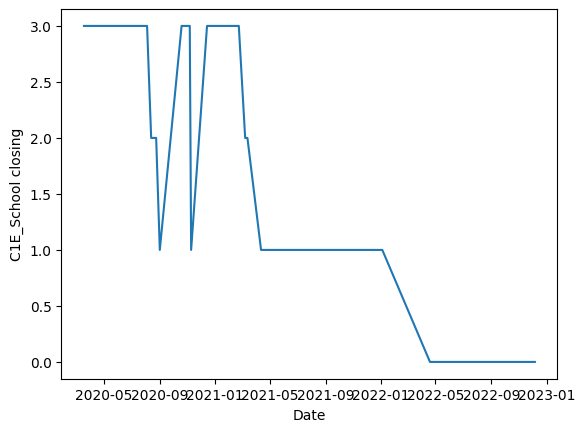

In [19]:
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(texas["Date"], format="%Y%m%d"), texas["Score"])
ax.set_xlabel("Date")
ax.set_ylabel("C1E_School closing")
plt.show()